In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import re

import nltk
import nltk.corpus  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.text import Text

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pickle

from joblib import dump, load

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [2]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1

Available CPUs: 8


In [3]:
pandarallel.initialize(nb_workers=num_processors-1, progress_bar=True)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
%%time
with open('full_df.pkl', 'rb') as f:
    df = pickle.load(f)

CPU times: total: 6.7 s
Wall time: 20.1 s


### Creating and Training a Logistic Regression Model

In [3]:
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

In [4]:
%%time

yelp = pd.read_json(path, orient='records', lines=True)
yelp.shape

CPU times: total: 1.92 s
Wall time: 33 s


(255717, 3)

In [5]:
yelp.head(5)

,text,label,lang
0,I love Deagan's. I do. I really do. The atmosp...,1,en
1,I love the classes at this gym. Zumba and. Rad...,1,en
2,The tables and floor were dirty. I was the onl...,0,en
3,I had an oil change at the 15515 N Scottsdale ...,0,en
4,The absolute WORST apartment complex I have ev...,0,en


In [6]:
# define X and y
X = yelp['text']
y = yelp['label']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (255717,)
y Shape: (255717,)


In [7]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (191787,) y_train: (191787,)
Testing records, X_test: (63930,) y_test: (63930,)


In [8]:
vect = CountVectorizer()

#vect = CountVectorizer(lowercase=False, stop_words='english',
    #                               max_df=0.8, min_df=0.2, max_features=10000, ngram_range=(1,3))

vect = CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3))

In [11]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=200)

In [12]:
%%time
# train the model
logreg.fit(vect.fit_transform(X_train), y_train)

CPU times: total: 10min 39s
Wall time: 13min


LogisticRegression(max_iter=200)

In [13]:
%%time
# make class predictions
y_pred = logreg.predict(vect.transform(X_test))

CPU times: total: 11.9 s
Wall time: 20.1 s


In [14]:
print(metrics.accuracy_score(y_test, y_pred))

0.9730330048490536


In [15]:
# calculate precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32217
           1       0.97      0.97      0.97     31713

    accuracy                           0.97     63930
   macro avg       0.97      0.97      0.97     63930
weighted avg       0.97      0.97      0.97     63930



In [16]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[31393   824]
 [  900 30813]]


In [17]:
element = 0
clf = logreg

text = X_test.iloc[element]
prediction = np.where(clf.predict(vect.transform([text])) < 1, "Negative", "Positive").tolist()[element]
print('Text: >>> ' + text + '\n' + 'Sentiment: >>> ' + prediction)

Text: >>> Cute place.  I wanted it to be good.  Very disappointing.  The chicken fried steak was actual very thin steak with gristle.  The eggs, bacon and hash browns were fine.  But how hard is it to mess these up?  The gravy on the steak and also biscuits is different than traditional gravy for these items. Underwhelming.  We won't come back.  But you might want to try it and see what you think.  The portions were big.  The flavor was a fail.  I suggest more pancake options.  Go with a white gravy and get rid of the poor quality steak.
The food is pricey for the quality of food you get.
Sentiment: >>> Negative


In [ ]:
#dump(logreg, 'logreg_model.joblib')

### Loading the Built Logistic Regression Model

In [18]:
logreg = load('logreg_model.joblib')

In [19]:
content = ['There seems to be some inherent bias in the algorithm']

In [20]:
content1 = vect.transform(content)

In [21]:
%%time
y_pred = logreg.predict(content1)

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
y_pred_class = np.where(y_pred < 1, 'Negative', 'Positive')
y_pred_prob = logreg.predict_proba(content1)

In [23]:
print(f'Text: {content[0]} \
    \nSentiment: {y_pred_class[0]} \
    \nProbability Negative: = {y_pred_prob[0][0]}\
    \nProbability Positive = {y_pred_prob[0][1]}\
    \n\n')

Text: There seems to be some inherent bias in the algorithm     
Sentiment: Negative     
Probability Negative: = 0.6577509155836185    
Probability Positive = 0.34224908441638147    




In [24]:
%%time
X_transformed = vect.transform(df['cleaned_text'])


CPU times: total: 6min 29s
Wall time: 9min 54s


In [25]:
%%time
probabilities = logreg.predict_proba(X_transformed)

CPU times: total: 969 ms
Wall time: 1.04 s


In [26]:
%%time
predicted_classes = logreg.predict(X_transformed)

CPU times: total: 906 ms
Wall time: 928 ms


In [27]:
%%time
probabilities_class_0 = probabilities[:, 0]
probabilities_class_1 = probabilities[:, 1]

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
%%time
data = pd.DataFrame({
    'text': df['cleaned_text'],
    'predicted_class': predicted_classes,
    'probability_class_0': probabilities_class_0,
    'probability_class_1': probabilities_class_1
})

CPU times: total: 46.9 ms
Wall time: 64.7 ms


In [29]:
%%time
data['predicted_class'] = data['predicted_class'].map({0: 'negative', 1: 'positive'})

CPU times: total: 0 ns
Wall time: 20.5 ms


In [30]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
data.head()

,text,predicted_class,probability_class_0,probability_class_1
0,LegalTech Artificial Intelligence Market 2019 ...,negative,0.993451,0.006549
1,"Observation, Simulation, And AI Join Forces To...",negative,0.989872,0.010128
2,Artificial intelligence yields new antibiotic ...,positive,0.440235,0.559765
3,"Forget ML, AI and Industry 4.0 – obsolescence ...",negative,0.694599,0.305401
4,How You Should Validate Machine Learning Model...,negative,1.000000,0.000000


In [34]:
data['word_count'] = data['text'].str.split().parallel_apply(len)

In [36]:
df.head()

,url,date,language,title,text,cleaned_text,tokens,lemmatized_text,dominant_topic
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,"['legaltech', 'artificial', 'intelligence', 'm...","['legaltech', 'artificial', 'intelligence', 'm...",8
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...","Observation, Simulation, And AI Join Forces To...","['observation', 'simulation', 'and', 'ai', 'jo...","['observation', 'simulation', 'ai', 'join', 'f...",9
2,http://usweekly.com/news/17/40964/Artificial-i...,2020-02-23,en,Artificial intelligence yields new antibiotic ...,\n\n\nArtificial intelligence yields new antib...,Artificial intelligence yields new antibiotic ...,"['artificial', 'intelligence', 'yields', 'new'...","['artificial', 'intelligence', 'yield', 'new',...",1
3,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...","Forget ML, AI and Industry 4.0 – obsolescence ...","['forget', 'ml', 'ai', 'industry', 'obsolescen...","['forget', 'ai', 'industry', 'obsolescence', '...",9
4,http://www.huewire.com/how-you-should-validate...,2023-07-21,en,How You Should Validate Machine Learning Model...,\n\nHow You Should Validate Machine Learning M...,How You Should Validate Machine Learning Model...,"['how', 'you', 'should', 'validate', 'machine'...","['validate', 'machine', 'learning', 'model', '...",9


In [37]:
data['topic'] = df['dominant_topic']
data['date'] = df['date']

In [39]:
data = data.rename(columns = {'probability_class_0': 'probability_negative', 'probability_class_1': 'probability_positive'})

In [42]:
too_short = data[data['word_count'] < 10]
too_short.shape

(65, 7)

In [43]:
sentiments = data[data['word_count'] >= 10]
sentiments.shape

(199612, 7)

In [44]:
keywords = ['data', 'ai', 'ml', 'machine learning', 'artificial intelligence', 'computer vision', 'gpt']

mask = sentiments['text'].str.lower().str.contains('|'.join(keywords))

irrel_arts = sentiments[~mask]
sentiments = sentiments[mask]

In [45]:
sentiments.shape

(199389, 7)

In [46]:
irrel_arts.shape

(223, 7)

In [47]:
def classify_sentiment(probability):
    if 0.4 <= probability <= 0.6:
        return 'neutral'
    elif probability > 0.6:
        return 'negative'
    else:
        return 'positive'

sentiments['pred_class'] = sentiments['probability_negative'].apply(classify_sentiment)

In [48]:
sentiments.pred_class.value_counts()

pred_class
negative    126880
positive     67430
neutral       5079
Name: count, dtype: int64

In [52]:
#with open('full_sentiments.pkl', 'wb') as f:
 #   pickle.dump(sentiments, f)

In [10]:
with open('full_sentiments.pkl', 'rb') as f:
    sentiments = pickle.load(f)

In [11]:
sentiments.shape

(199389, 8)

### Word Counts

In [56]:
sentiments.topic.value_counts()

topic
9    42008
2    38002
3    23006
6    19281
8    18519
4    17159
1    14282
7    10324
5     9926
0     6882
Name: count, dtype: int64

In [49]:
percentiles = [0,10, 25, 50, 75, 80, 99, 100]

# Get the specified percentiles of the "word_count" column
percentile_values = np.percentile(sentiments['word_count'], percentiles)

# Display the results
for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value}")

0th percentile: 10.0
10th percentile: 522.0
25th percentile: 697.0
50th percentile: 959.0
75th percentile: 1354.0
80th percentile: 1467.0
99th percentile: 4394.239999999991
100th percentile: 43613.0


In [50]:
words = sentiments[sentiments['word_count'] <= 10000]
words.shape

(199043, 8)

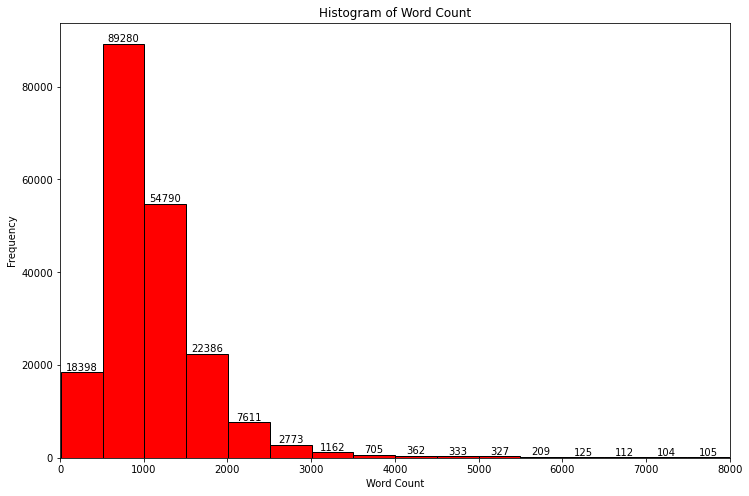

In [51]:
plt.figure(figsize=(12,8))
_, _, bars = plt.hist(words['word_count'], bins=20, color='red', edgecolor='black')
plt.bar_label(bars)
plt.xlim(0,8000)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')

plt.savefig('hist.jpg',bbox_inches='tight')

plt.show()

### Targeted Sentiment Analysis

In [129]:
%%time
with open('entities.pkl', 'rb') as f:
    ents = pickle.load(f)

CPU times: total: 16.8 s
Wall time: 3min 26s


In [131]:
def has_name(entities, name):
    return 1 if any(entity[0].lower() == name.lower() for entity in entities) else 0

In [6]:
%%time
# List of names to check for
names_to_check = ['google', 'ibm', 'microsoft', 'amazon', 'openai', 'us', 'india', 'china', 'europe', 'biden', 'elon musk', 'sam altman']

# Create columns for each name
for name in names_to_check:
    ents[name.lower()] = ents['entities'].apply(lambda x: has_name(x, name))
    print(f'Finished checking {name} entitiy')

Finished checking google entitiy
Finished checking ibm entitiy
Finished checking microsoft entitiy
Finished checking amazon entitiy
Finished checking openai entitiy
Finished checking us entitiy
Finished checking india entitiy
Finished checking china entitiy
Finished checking europe entitiy
Finished checking biden entitiy
Finished checking elon musk entitiy
Finished checking sam altman entitiy
CPU times: total: 2min 4s
Wall time: 2min 39s


### Full entities

In [132]:
auto = ['ford', 'toyota', 'hyundai', 'honda', 'tesla']
finance = ['citi', 'goldman sachs', 'jp morgan', 'morgan stanley', 'wells fargo', 'nyse']
health = ['merck', 'pfizer', 'kaiser']
telcom = ['verizon', 'at&t']
tech = ['google', 'ibm', 'microsoft', 'amazon', 'apple', 'meta', 'openai']
gov = ['fda', 'cdc', 'fbi', 'cia']

full_names = [auto, finance, health, telcom, tech, gov]

In [133]:
categories = ['auto', 'finance', 'health', 'telcom', 'tech', 'gov']
for category, names in zip(categories, full_names):
    for name in names:
        ents[f'{category}_{name.lower()}'] = ents['entities'].apply(lambda x: has_name(x, name))
        print(f'Finished checking {name} entity in {category} category')

Finished checking ford entity in auto category
Finished checking toyota entity in auto category
Finished checking hyundai entity in auto category
Finished checking honda entity in auto category
Finished checking tesla entity in auto category
Finished checking citi entity in finance category
Finished checking goldman sachs entity in finance category
Finished checking jp morgan entity in finance category
Finished checking morgan stanley entity in finance category
Finished checking wells fargo entity in finance category
Finished checking nyse entity in finance category
Finished checking merck entity in health category
Finished checking pfizer entity in health category
Finished checking kaiser entity in health category
Finished checking verizon entity in telcom category
Finished checking at&t entity in telcom category
Finished checking google entity in tech category
Finished checking ibm entity in tech category
Finished checking microsoft entity in tech category
Finished checking amazon en

In [134]:
df_counts = pd.DataFrame(index=[f'{category}_{name.lower()}' for category, names in zip(categories, full_names) for name in names])

# Add a count column
df_counts['count'] = df_counts.index.map(lambda col: ents[col].sum())


In [135]:
df_counts

,count
auto_ford,1794
auto_toyota,1066
auto_hyundai,951
auto_honda,513
auto_tesla,5489
finance_citi,140
finance_goldman sachs,1543
finance_jp morgan,114
finance_morgan stanley,829
finance_wells fargo,294


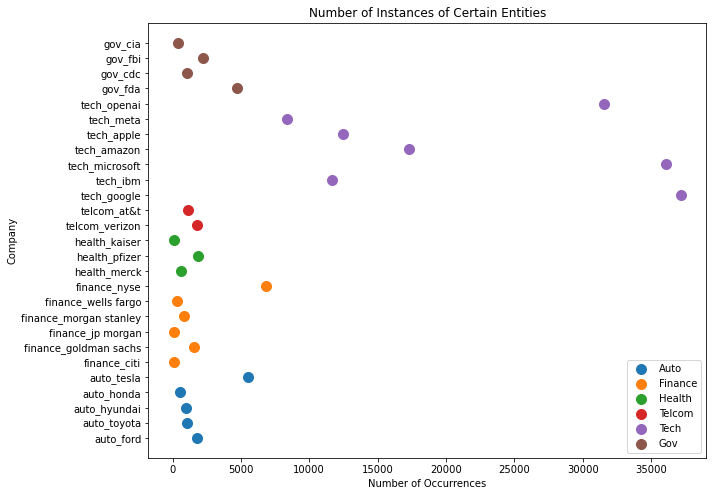

In [142]:
auto_df = df_counts[df_counts.index.str.startswith('auto')]
finance_df = df_counts[df_counts.index.str.startswith('finance')]
health_df = df_counts[df_counts.index.str.startswith('health')]
telcom_df = df_counts[df_counts.index.str.startswith('telcom')]
tech_df = df_counts[df_counts.index.str.startswith('tech')]
gov_df = df_counts[df_counts.index.str.startswith('gov')]

# Create a bubble chart
fig, ax = plt.subplots(figsize=(10, 8))

# Auto industry
ax.scatter(auto_df['count'], range(len(auto_df)), label='Auto', s=100)

# Finance industry
ax.scatter(finance_df['count'], range(len(auto_df), len(auto_df) + len(finance_df)), label='Finance', s=100)

# Health industry
ax.scatter(health_df['count'], range(len(auto_df) + len(finance_df), len(auto_df) + len(finance_df) + len(health_df)),
           label='Health', s=100)

# Telcom industry
ax.scatter(telcom_df['count'], range(len(auto_df) + len(finance_df) + len(health_df),
                                    len(auto_df) + len(finance_df) + len(health_df) + len(telcom_df)),
           label='Telcom', s=100)

# Tech industry
ax.scatter(tech_df['count'], range(len(auto_df) + len(finance_df) + len(health_df) + len(telcom_df),
                                  len(auto_df) + len(finance_df) + len(health_df) + len(telcom_df) + len(tech_df)),
           label='Tech', s=100)

# Gov industry
ax.scatter(gov_df['count'], range(len(auto_df) + len(finance_df) + len(health_df) + len(telcom_df) + len(tech_df),
                                  len(auto_df) + len(finance_df) + len(health_df) + len(telcom_df) + len(tech_df) + len(gov_df)),
           label='Gov', s=100)

# Set labels and title
ax.set_xlabel('Number of Occurrences')
ax.set_ylabel('Company')
ax.set_yticks(range(len(df_counts)))
ax.set_yticklabels(df_counts.index)
ax.set_title('Number of Instances of Certain Entities')
# Add legend in the bottom right
ax.legend(loc='lower right')

# Show the plot
plt.show()

In [7]:
ents.head()

,url,date,language,title,text,cleaned_text,tokens,entities,google,ibm,microsoft,amazon,openai,us,india,china,europe,biden,elon musk,sam altman
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,"['legaltech', 'artificial', 'intelligence', 'm...",[(LegalTech Artificial Intelligence Market 201...,0,0,0,0,0,0,0,0,0,0,0,0
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...","Observation, Simulation, And AI Join Forces To...","['observation', 'simulation', 'and', 'ai', 'jo...","[(Observation, Simulation, ORG), (AI Join Forc...",0,0,0,0,0,0,0,0,0,0,0,0
2,http://usweekly.com/news/17/40964/Artificial-i...,2020-02-23,en,Artificial intelligence yields new antibiotic ...,\n\n\nArtificial intelligence yields new antib...,Artificial intelligence yields new antibiotic ...,"['artificial', 'intelligence', 'yields', 'new'...","[(23, CARDINAL), (Todays newsWorldU.S. Nationa...",0,0,0,0,0,0,0,0,0,0,0,0
3,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...","Forget ML, AI and Industry 4.0 – obsolescence ...","['forget', 'ml', 'ai', 'industry', 'obsolescen...","[(AI, ORG), (Editor, PERSON), (Multimedia, GPE...",0,0,0,0,0,0,0,0,0,0,0,0
4,http://www.huewire.com/how-you-should-validate...,2023-07-21,en,How You Should Validate Machine Learning Model...,\n\nHow You Should Validate Machine Learning M...,How You Should Validate Machine Learning Model...,"['how', 'you', 'should', 'validate', 'machine'...","[(Patryk Miziuła, PERSON), (PhD, WORK_OF_ART),...",0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
columns_to_drop = ['url', 'language', 'title', 'tokens', 'text']

# Drop the specified columns
ents.drop(columns=columns_to_drop, inplace=True)

In [10]:
ents.head()

,date,cleaned_text,entities,google,ibm,microsoft,amazon,openai,us,india,china,europe,biden,elon musk,sam altman
0,2020-02-26,LegalTech Artificial Intelligence Market 2019 ...,[(LegalTech Artificial Intelligence Market 201...,0,0,0,0,0,0,1,1,1,0,0,0
1,2021-07-05,"Observation, Simulation, And AI Join Forces To...","[(Observation, Simulation, ORG), (AI Join Forc...",0,0,0,0,0,0,0,0,0,0,0,0
2,2020-02-23,Artificial intelligence yields new antibiotic ...,"[(23, CARDINAL), (Todays newsWorldU.S. Nationa...",0,0,0,0,0,0,0,0,0,0,0,0
3,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","[(AI, ORG), (Editor, PERSON), (Multimedia, GPE...",0,0,0,0,0,1,0,1,0,0,0,0
4,2023-07-21,How You Should Validate Machine Learning Model...,"[(Patryk Miziuła, PERSON), (PhD, WORK_OF_ART),...",0,0,0,0,0,0,0,0,0,1,0,0


In [7]:
ents['word_count'] = entities['word_count'] 

In [8]:
#with open('ent_binary.pkl', 'wb') as f:
 #   pickle.dump(ents, f)


In [6]:
with open('ent_binary.pkl', 'rb') as f:
    ents = pickle.load(f)

In [14]:
ents.shape

(199677, 15)

In [4]:
with open('entities.pkl', 'rb') as f:
    entities = pickle.load(f)

In [17]:
entities.head()

,url,date,language,title,text,cleaned_text,tokens,entities
0,http://galusaustralis.com/2020/02/486473/legal...,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,"['legaltech', 'artificial', 'intelligence', 'm...",[(LegalTech Artificial Intelligence Market 201...
1,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force...","Observation, Simulation, And AI Join Forces To...","['observation', 'simulation', 'and', 'ai', 'jo...","[(Observation, Simulation, ORG), (AI Join Forc..."
2,http://usweekly.com/news/17/40964/Artificial-i...,2020-02-23,en,Artificial intelligence yields new antibiotic ...,\n\n\nArtificial intelligence yields new antib...,Artificial intelligence yields new antibiotic ...,"['artificial', 'intelligence', 'yields', 'new'...","[(23, CARDINAL), (Todays newsWorldU.S. Nationa..."
3,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence ...","\n\nForget ML, AI and Industry 4.0 – obsolesce...","Forget ML, AI and Industry 4.0 – obsolescence ...","['forget', 'ml', 'ai', 'industry', 'obsolescen...","[(AI, ORG), (Editor, PERSON), (Multimedia, GPE..."
4,http://www.huewire.com/how-you-should-validate...,2023-07-21,en,How You Should Validate Machine Learning Model...,\n\nHow You Should Validate Machine Learning M...,How You Should Validate Machine Learning Model...,"['how', 'you', 'should', 'validate', 'machine'...","[(Patryk Miziuła, PERSON), (PhD, WORK_OF_ART),..."


In [5]:
entities['word_count'] = entities['cleaned_text'].str.split().parallel_apply(len)

In [12]:
ents.shape

(199677, 16)

In [13]:
ents1 = ents[ents['word_count'] >= 10]

In [14]:
ents1.shape

(199612, 16)

In [16]:
keywords = ['data', 'ai', 'ml', 'machine learning', 'artificial intelligence', 'computer vision', 'gpt']

mask = ents1['cleaned_text'].str.lower().str.contains('|'.join(keywords))

irrel_arts = ents1[~mask]
ents2 = ents1[mask]

In [17]:
ents2.shape

(199389, 16)

In [19]:
sentiments.head()

,text,predicted_class,probability_negative,probability_positive,word_count,topic,date,pred_class
0,LegalTech Artificial Intelligence Market 2019 ...,negative,0.993451,0.006549,910,8,2020-02-26,negative
1,"Observation, Simulation, And AI Join Forces To...",negative,0.989872,0.010128,847,9,2021-07-05,negative
2,Artificial intelligence yields new antibiotic ...,positive,0.440235,0.559765,160,1,2020-02-23,neutral
3,"Forget ML, AI and Industry 4.0 – obsolescence ...",negative,0.694599,0.305401,1892,9,2021-03-26,negative
4,How You Should Validate Machine Learning Model...,negative,1.000000,0.000000,3341,9,2023-07-21,negative


In [96]:
ents2['pred_class'] = sentiments['pred_class']
ents2['probability_negative'] = sentiments['probability_negative']
ents2['probability_positive'] = sentiments['probability_positive']
ents2['topic'] = sentiments['topic']


C:\Users\tfurr\AppData\Local\Temp\ipykernel_30400\2693029854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ents2['pred_class'] = sentiments['pred_class']
C:\Users\tfurr\AppData\Local\Temp\ipykernel_30400\2693029854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ents2['probability_negative'] = sentiments['probability_negative']
C:\Users\tfurr\AppData\Local\Temp\ipykernel_30400\2693029854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [99]:
ents2.head()

,date,cleaned_text,entities,google,ibm,microsoft,amazon,openai,us,india,china,europe,biden,elon musk,sam altman,word_count,pred_class,probability_negative,probability_positive,topic
0,2020-02-26,LegalTech Artificial Intelligence Market 2019 ...,[(LegalTech Artificial Intelligence Market 201...,0,0,0,0,0,0,1,1,1,0,0,0,910,negative,0.993451,0.006549,8
1,2021-07-05,"Observation, Simulation, And AI Join Forces To...","[(Observation, Simulation, ORG), (AI Join Forc...",0,0,0,0,0,0,0,0,0,0,0,0,847,negative,0.989872,0.010128,9
2,2020-02-23,Artificial intelligence yields new antibiotic ...,"[(23, CARDINAL), (Todays newsWorldU.S. Nationa...",0,0,0,0,0,0,0,0,0,0,0,0,160,neutral,0.440235,0.559765,1
3,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","[(AI, ORG), (Editor, PERSON), (Multimedia, GPE...",0,0,0,0,0,1,0,1,0,0,0,0,1892,negative,0.694599,0.305401,9
4,2023-07-21,How You Should Validate Machine Learning Model...,"[(Patryk Miziuła, PERSON), (PhD, WORK_OF_ART),...",0,0,0,0,0,0,0,0,0,1,0,0,3341,negative,1.000000,0.000000,9


In [100]:
#with open('target_sent.pkl', 'wb') as f:
 #   pickle.dump(ents2, f)

In [4]:
with open('target_sent.pkl', 'rb') as f:
    ents = pickle.load(f)

In [158]:
with open('target_sent.pkl', 'rb') as f:
    ents1 = pickle.load(f)

In [102]:
ents.head()

,date,cleaned_text,entities,google,ibm,microsoft,amazon,openai,us,india,china,europe,biden,elon musk,sam altman,word_count,pred_class,probability_negative,probability_positive,topic
0,2020-02-26,LegalTech Artificial Intelligence Market 2019 ...,[(LegalTech Artificial Intelligence Market 201...,0,0,0,0,0,0,1,1,1,0,0,0,910,negative,0.993451,0.006549,8
1,2021-07-05,"Observation, Simulation, And AI Join Forces To...","[(Observation, Simulation, ORG), (AI Join Forc...",0,0,0,0,0,0,0,0,0,0,0,0,847,negative,0.989872,0.010128,9
2,2020-02-23,Artificial intelligence yields new antibiotic ...,"[(23, CARDINAL), (Todays newsWorldU.S. Nationa...",0,0,0,0,0,0,0,0,0,0,0,0,160,neutral,0.440235,0.559765,1
3,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence ...","[(AI, ORG), (Editor, PERSON), (Multimedia, GPE...",0,0,0,0,0,1,0,1,0,0,0,0,1892,negative,0.694599,0.305401,9
4,2023-07-21,How You Should Validate Machine Learning Model...,"[(Patryk Miziuła, PERSON), (PhD, WORK_OF_ART),...",0,0,0,0,0,0,0,0,0,1,0,0,3341,negative,1.000000,0.000000,9


In [25]:
ents.columns[3:15]

Index(['google', 'ibm', 'microsoft', 'amazon', 'openai', 'us', 'india',
       'china', 'europe', 'biden', 'elon musk', 'sam altman'],
      dtype='object')

In [121]:
ents.pred_class.value_counts(normalize=True)

pred_class
negative   0.636344
positive   0.338183
neutral    0.025473
Name: proportion, dtype: float64

In [24]:
ents[ents['openai'] == 1].pred_class.value_counts(normalize=True)

pred_class
negative   0.785051
positive   0.198797
neutral    0.016152
Name: proportion, dtype: float64

In [6]:
negs = []
columns = []
for column in ents.columns[3:15]:
    columns.append(column)
    s = ents[ents[column] == 1].pred_class.value_counts(normalize=True)
    neg = s['negative']
    negs.append(neg)

In [7]:
negs.append(ents.pred_class.value_counts(normalize=True)['negative'])

In [8]:
columns.append('Overall')

In [9]:
neg_df = pd.DataFrame({'entity': columns,'Negative_sent_score': negs})

In [10]:
neg_df

,entity,Negative_sent_score
0,google,0.706764
1,ibm,0.457623
2,microsoft,0.698452
3,amazon,0.663037
4,openai,0.785051
5,us,0.640935
6,india,0.572415
7,china,0.594523
8,europe,0.519330
9,biden,0.845145


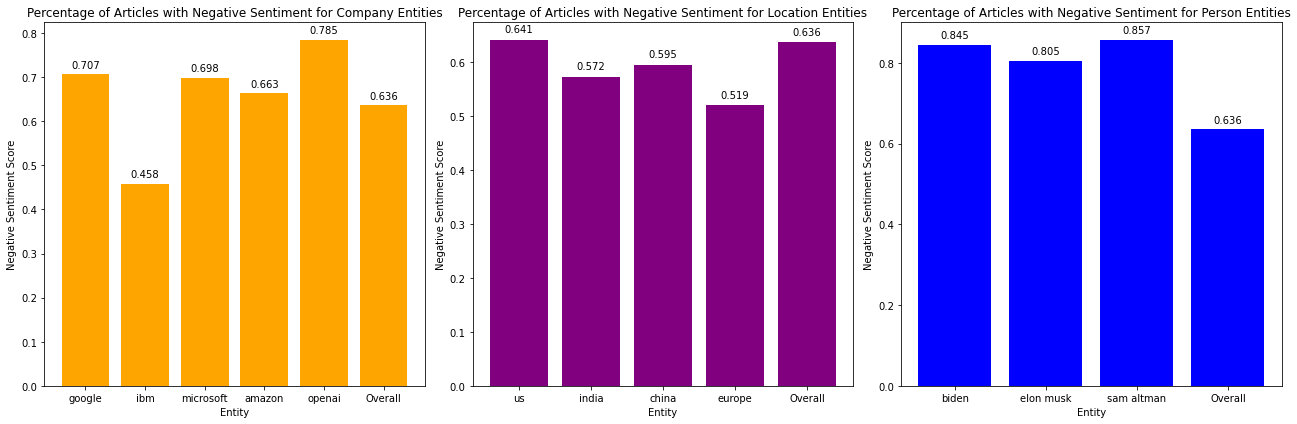

In [23]:
import matplotlib.pyplot as plt

# Assuming you have three different DataFrames named neg_df1, neg_df2, neg_df3
rows1 = neg_df.iloc[[0, 1, 2, 3, 4, 12]]
rows2 = neg_df.iloc[[5, 6, 7, 8, 12]]
rows3 = neg_df.iloc[[9,10,11, 12]]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for the first DataFrame
axs[0].bar(rows1['entity'], rows1['Negative_sent_score'], color='orange')
axs[0].set_xlabel('Entity')
axs[0].set_ylabel('Negative Sentiment Score')
axs[0].set_title('Percentage of Articles with Negative Sentiment for Company Entities')

for i, value in enumerate(rows1['Negative_sent_score']):
    axs[0].text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Plot for the second DataFrame
axs[1].bar(rows2['entity'], rows2['Negative_sent_score'], color='purple')
axs[1].set_xlabel('Entity')
axs[1].set_ylabel('Negative Sentiment Score')
axs[1].set_title('Percentage of Articles with Negative Sentiment for Location Entities')

for i, value in enumerate(rows2['Negative_sent_score']):
    axs[1].text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

# Plot for the third DataFrame
axs[2].bar(rows3['entity'], rows3['Negative_sent_score'], color='blue')
axs[2].set_xlabel('Entity')
axs[2].set_ylabel('Negative Sentiment Score')
axs[2].set_title('Percentage of Articles with Negative Sentiment for Person Entities')

for i, value in enumerate(rows3['Negative_sent_score']):
    axs[2].text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [28]:
ibms = ents[ents['ibm'] == 1]
ibms.shape

(11669, 20)

In [105]:
ents.iloc[91:110]

,date,cleaned_text,entities,google,ibm,microsoft,amazon,openai,us,india,china,europe,biden,elon musk,sam altman,word_count,pred_class,probability_negative,probability_positive,topic
91,2023-08-09,Google and Universal Music Reportedly Want to ...,"[(Google, ORG), (Universal Music Reportedly Wa...",1,0,0,0,0,0,0,0,0,0,0,0,580,negative,0.999998,0.000002,9
92,2020-12-04,Google’s Co-Head of Ethical AI Timnit Ge...,"[(Google’s Co-Head of, ORG), (Technology News ...",1,0,1,1,1,1,1,0,0,0,0,0,2265,negative,1.000000,0.000000,9
93,2020-03-11,Healthcare Artificial Intelligence Market Set ...,[(Healthcare Artificial Intelligence Market Se...,1,1,0,1,0,1,0,1,0,0,0,0,1187,positive,0.000000,1.000000,8
94,2023-08-07,Pioneering Breakthrough: AI Revolutionizes Wea...,"[(Pioneering Breakthrough, PERSON), (The Ghana...",0,0,0,0,0,0,0,0,0,0,0,0,932,negative,0.988987,0.011013,1
95,2020-01-11,Voices in AI – Episode 104: A Conversation wit...,"[(AI, GPE), (Gigaom, PERSON), (ContactSign inS...",1,0,1,0,1,0,0,0,1,0,0,0,1597,negative,1.000000,0.000000,9
96,2021-07-30,Australian Court Rules That AI Can Be an Inven...,"[(Australian Court, ORG), (OnionThe InventoryW...",0,0,0,0,0,1,1,0,0,0,0,0,667,negative,0.932018,0.067982,3
97,2022-12-14,Why Google Isn’t Rushing Forward With AI Chatb...,[(AI ChatbotsThe A.V. ClubDeadspinGizmodoJalop...,1,0,1,0,1,0,0,0,0,0,0,0,845,negative,0.999874,0.000126,9
98,2023-09-14,Amazon creates AI tool for sellers to generat...,"[(Amazon, ORG), (AI, ORG), (Nooke-Bookse, PERS...",0,0,0,1,0,0,0,0,0,0,0,0,765,negative,0.999544,0.000456,9
99,2023-07-13,Meta to release commercial AI model like ChatG...,"[(AI, ORG), (Bard, ORG), (Media – Gulf News, O...",1,0,1,0,1,0,0,0,0,0,1,0,886,negative,0.999429,0.000571,9
100,2023-08-27,Roughly Half of Data Scientists Consider Model...,"[(Roughly Half, CARDINAL), (Model Monitoring, ...",0,0,0,0,0,0,0,0,0,0,0,0,310,negative,0.996346,0.003654,9


### Text Summarization

In [32]:
import ktrain
from ktrain import text
ts = text.TransformerSummarizer()

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

C:\Users\tfurr\anaconda\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tfurr\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/facebook/bart-large-cnn/40041830399afb5348525ef8354b007ecec4286fdf3524f7e6b54377e17096cb?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1702230787&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMjIzMDc4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9mYWNlYm9vay9iYXJ0LWxhcmdlLWNubi80MDA0MTgzMDM5OWFmYjUzNDg1MjVlZjgzNTRiMDA3ZWNlYzQyODZmZGYzNTI0ZjdlNmI1NDM3N2UxNzA5NmNiP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=Pvetxpzi8yE9ROh%7EO8%7EhfZOP%7EcLJLBZ42dF0tcsvlepBYFwkI9R9QU7-l6JEBT3GrJkuIi8nyllaNWiNGJ-YePKCoQRDRp35bu83T8JHYWrF%7EoTMmUSLZZF-9BHEt1b77QkhnSrUqtJa8DaWDayhhO3p59t8nnK0-D6RYVC0ypjw7pf43eMLix9AeCH2Yz0mhiIZh8m3XMaA--%7EEe6w7%7EBvbGTmUbXUPqJaywDbvvcCGI3ELQ7ytF3cPUT99k0RyYfxb7g2zvhP6nYX3%7EcQX5ul6r44RfIgSxKYDMF5TzVK0ZhTwR6y2fDXYoalusv-r6M6RvssJVrdZ5MaFHu3U7w__&Key-Pair-I

model.safetensors:  87%|########7 | 1.42G/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [106]:
test = str(ents['cleaned_text'].iloc[103])

In [107]:
test

'How Generative AI Changes CreativityNavigation MenuSubscribeSign InAccount MenuSearch MenuClose menuSearchCLEARSUGGESTED TOPICSExplore HBRDiversityLatestThe MagazineAscendPodcastsVideoStoreWebinarsNewslettersPopular TopicsManaging YourselfLeadershipStrategyManaging TeamsGenderInnovationWork-life BalanceAll TopicsFor SubscribersThe Big IdeaData & VisualsReading ListsCase SelectionsHBR LearningSubscribeMy AccountMy LibraryTopic FeedsOrdersAccount SettingsEmail PreferencesLog OutSign InSubscribeDiversityLatestPodcastsVideoThe MagazineAscendStoreWebinarsNewslettersAll TopicsThe Big IdeaData & VisualsReading ListsCase SelectionsHBR LearningMy LibraryAccount SettingsLog OutSign InYour CartYour Shopping Cart is empty.Visit Our StoreGuest User SubscriberMy LibraryTopic FeedsOrdersAccount SettingsEmail PreferencesLog OutReading ListReading ListsYou have 1 free articles left this month.You are reading your last free article for this month.Subscribe for unlimited access.Create an account to read

In [109]:
%%time 
ts.summarize(test)

CPU times: total: 45.8 s
Wall time: 13.6 s


'How Generative AI Changes Creativity is a special series from HBR IdeaCast. Each week, HBR editor in chief Adi Ignatius speaks with experts and business leaders about the impact of generative AI on productivity, creativity and innovation. The episodes publish in the IdeaCast feed each Thursday in May, after the regular Tuesday episode.'

### Wordcloud

In [146]:
from wordcloud import WordCloud

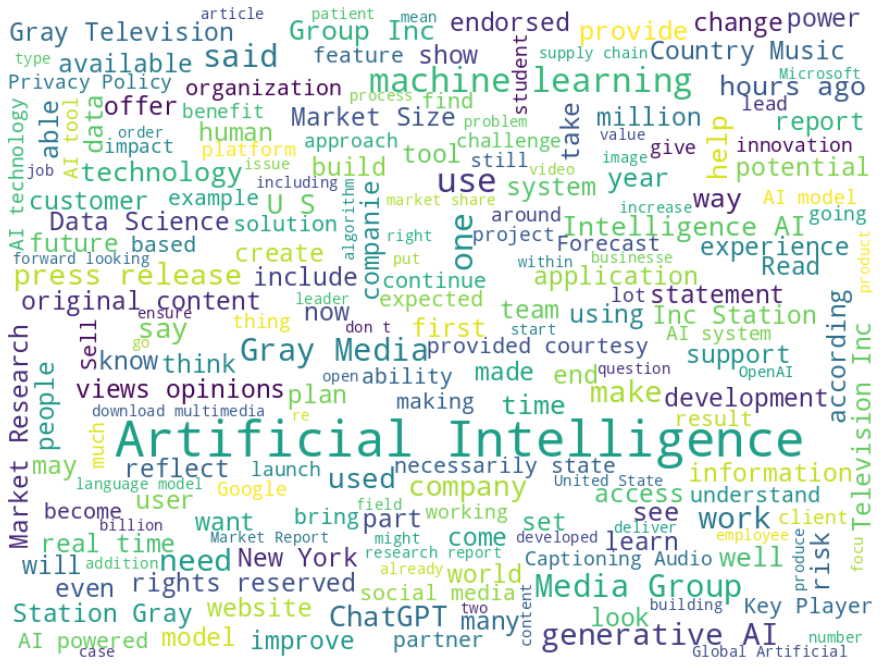

In [155]:
sample_size = 30000
random_sample = ents['cleaned_text'].sample(n=sample_size, random_state=42)

# Combine the sampled text into a single string
text = ' '.join(random_sample.astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=600, max_words=200,background_color='white').generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment over Time

In [166]:
average_probabilities = ents1.groupby('date')['probability_positive'].mean().reset_index()


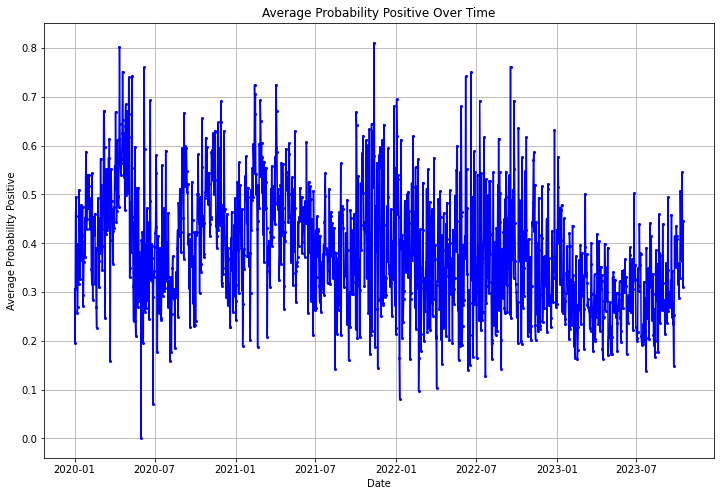

In [171]:

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(average_probabilities['date'].values, average_probabilities['probability_positive'].values, marker='o', linestyle='-', color='blue', markersize=2)

# Customize the plot
plt.title('Average Probability Positive Over Time')
plt.xlabel('Date')
plt.ylabel('Average Probability Positive')
plt.grid(True)
plt.show()